In [1]:
import os
import glob
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import gradio as gr
import cv2
import matplotlib.pyplot as plt

from utils.prediction import get_sr_image
from utils.config import config



In [2]:
def load_image(path):
    img = Image.open(path)
    
    was_grayscale = len(img.getbands()) == 1
    
    if was_grayscale or len(img.getbands()) == 4:
        img = img.convert('RGB')
    
    return was_grayscale, np.array(img)

In [3]:
# model_name = "srresnet"
model_name = "srgan"

In [4]:
model_key = f"{model_name}"

In [5]:
weights_directory = os.path.abspath(f"weights/{model_key}")

file_path = os.path.join(weights_directory, "generator.h5")

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Add, Lambda
from tensorflow.python.keras.layers import PReLU

from utils.normalization import normalize_01, denormalize_m11


upsamples_per_scale = {
    2: 1,
    4: 2,
    8: 3
}


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)


def upsample(x_in, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = Lambda(pixel_shuffle(scale=2))(x)
    return PReLU(shared_axes=[1, 2])(x)


def residual_block(block_input, num_filters, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(block_input)
    x = BatchNormalization(momentum=momentum)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = Add()([block_input, x])
    return x


def build_srresnet(scale=4, num_filters=64, num_res_blocks=16):
    if scale not in upsamples_per_scale:
        raise ValueError(f"available scales are: {upsamples_per_scale.keys()}")

    num_upsamples = upsamples_per_scale[scale]

    lr = Input(shape=(None, None, 3))
    x = Lambda(normalize_01)(lr)

    x = Conv2D(num_filters, kernel_size=9, padding='same')(x)
    x = x_1 = PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_blocks):
        x = residual_block(x, num_filters)

    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_1, x])

    for _ in range(num_upsamples):
        x = upsample(x, num_filters * 4)

    x = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    sr = Lambda(denormalize_m11)(x)

    return Model(lr, sr)


In [7]:


model = build_srresnet(scale=4)

os.makedirs(weights_directory, exist_ok=True)
weights_file = f'{weights_directory}/generator.h5'


model.load_weights(weights_file)

results_path = f"output/{model_key}/"

os.makedirs(results_path, exist_ok=True)



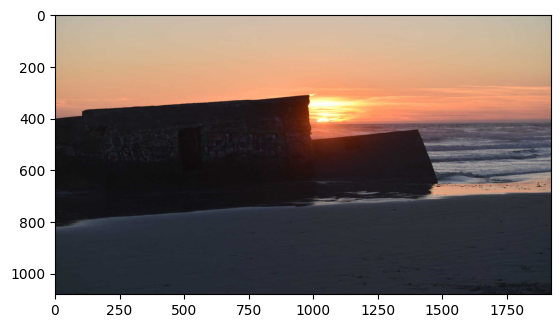

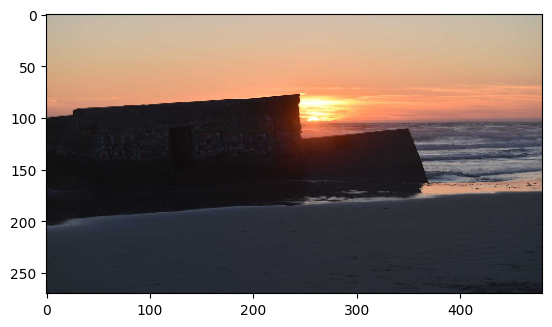

1/1 [==============================] - 4s 4s/step


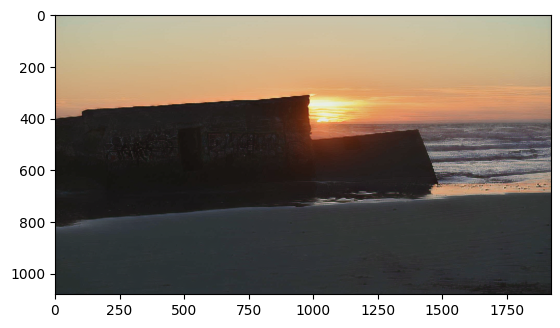

PSNR: 27.57221794128418 dB
SSIM: 0.8561973571777344
1/1 [==============================] - 3s 3s/step
PSNR: 19.63824462890625 dB
SSIM: 0.6739489436149597
1/1 [==============================] - 3s 3s/step
PSNR: 13.783679008483887 dB
SSIM: 0.40645384788513184
1/1 [==============================] - 3s 3s/step
PSNR: 24.86970329284668 dB
SSIM: 0.7448129653930664
1/1 [==============================] - 3s 3s/step
PSNR: 14.666569709777832 dB
SSIM: 0.34818145632743835
1/1 [==============================] - 3s 3s/step
PSNR: 23.844457626342773 dB
SSIM: 0.7260501980781555
1/1 [==============================] - 3s 3s/step
PSNR: 20.63990592956543 dB
SSIM: 0.6224948763847351
1/1 [==============================] - 3s 3s/step
PSNR: 20.654417037963867 dB
SSIM: 0.6955957412719727
1/1 [==============================] - 3s 3s/step
PSNR: 17.660808563232422 dB
SSIM: 0.36680713295936584
1/1 [==============================] - 3s 3s/step
PSNR: 15.38086986541748 dB
SSIM: 0.3962462842464447
1/1 [=================

In [8]:
image_paths = glob.glob("data/test/*")

psnr_values = []
ssim_values = []
for image_path in image_paths[:20]:
    # Degrade the image
    hr = cv2.imread(image_path)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
    if image_path==image_paths[0]:
        plt.imshow(hr)
        plt.show()
    lr = cv2.resize(hr, (hr.shape[1] // 4, hr.shape[0] // 4), interpolation=cv2.INTER_CUBIC)
    if image_path==image_paths[0]:
        plt.imshow(lr)
        plt.show()
    sr = get_sr_image(model, lr)
    sr = np.array(sr)
    if image_path==image_paths[0]:
        plt.imshow(sr)
        plt.show()
    # Compute the PSNR 
    psnr = tf.image.psnr(sr, hr, max_val=255)
    
    # Compute the SSIM
    ssim = tf.image.ssim(sr, hr, max_val=255, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    
    print(f"PSNR: {psnr} dB")
    print(f"SSIM: {ssim}")
    psnr_values.append(psnr)
    ssim_values.append(ssim)




In [9]:
print(f"Average PSNR: {np.mean(psnr_values)} dB")
print(f"Average SSIM: {np.mean(ssim_values)}")

Average PSNR: 18.24386215209961 dB
Average SSIM: 0.5464171767234802


In [27]:
def use_srresnet(image):
    
    lr = image
    
    model = build_srresnet(scale=4)
    model_key = f"srresnet"
    weights_directory = os.path.abspath(f"weights/{model_key}")
    os.makedirs(weights_directory, exist_ok=True)
    weights_file = f'{weights_directory}/generator.h5'
    model.load_weights(weights_file)

    sr = get_sr_image(model, lr)
    
    return sr

def use_srgan(image):
        
        lr = image
        
        model = build_srresnet(scale=4)
        model_key = f"srgan"
        weights_directory = os.path.abspath(f"weights/{model_key}")
        os.makedirs(weights_directory, exist_ok=True)
        weights_file = f'{weights_directory}/generator.h5'
        model.load_weights(weights_file)
    
        sr = get_sr_image(model, lr)
        
        return sr


In [31]:
with gr.Blocks() as demo:

    image = gr.Image(label="Input low resolution image")
    with gr.Row():
        
        button_use_srresnet = gr.Button("Use SRResNet")
        button_use_srgan = gr.Button("Use SRGAN")
    
    with gr.Row():
        output_srresnet = gr.Image(label="Output SRResNet")
        output_srgan = gr.Image(label="Output SRGAN")

    button_use_srresnet.click(fn=use_srresnet, inputs=[image], outputs=[output_srresnet],api_name="SRResNet")
    button_use_srgan.click(fn=use_srgan, inputs=[image], outputs=[output_srgan],api_name="SRGAN")

demo.launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.
